In [166]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [171]:
with open(r"/home/ginko/mlcourse/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])

In [2]:
def write_to_submission_file(predicted_labels, out_file,
                            target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                               index=np.arange(1, predicted_labels.shape[0] + 1),
                               columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
times = ['time%s' % i for i in range(1,11)]
data_dir = "/home/ginko/mlcourse/data_alice/"
train_df = pd.read_csv(data_dir + "train_sessions.csv", parse_dates=times, index_col = "session_id" )
test_df = pd.read_csv(data_dir + "test_sessions.csv", parse_dates=times, index_col = "session_id")

train_df = train_df.sort_values(by='time1')

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


In [4]:
sites = ['site%s' % i for i in range(1, 11)]
#train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', 
#                                              sep = ' ',
#                                              index=None,
#                                              header=None)
#
#test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', 
#                                              sep = ' ',
#                                              index=None,
#                                              header=None)

In [6]:
%%time 
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
    
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)

y_train = train_df['target'].astype('int').values
print(X_train.shape, X_test.shape)

(253561, 50000) (82797, 50000)
CPU times: user 30.4 s, sys: 658 ms, total: 31.1 s
Wall time: 31.3 s


In [7]:
time_split = TimeSeriesSplit(n_splits=10)
logit = LogisticRegression(random_state=17, C=1, solver='liblinear')

def cv_scores(x, y, crossval=time_split, c=1):
    logreg = LogisticRegression(random_state=17, C=c, solver='liblinear')
    return cross_val_score(logreg, x, y, cv=crossval, scoring='roc_auc', n_jobs=3) 


In [12]:
c_values = np.logspace(-2, 2, 10)
logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=4, 
                                  cv=time_split, verbose=1)

In [13]:
#%%time
#logit_grid_searcher.fit(X_train_new, y_train)

In [14]:
#logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

In [15]:
#logit = LogisticRegression(C=0.21544, random_state=17, solver='liblinear')
#logit.fit(X_train_new, y_train)

In [16]:
#prediction1 = logit.predict_proba(X_test_new)[:,1]
#write_to_submission_file(prediction1, 'submission3.csv')

# Freeride

## EDA on time dataset
**Hypothesis:**
1. Alice is surfing the web with some particoular pattern during the day, week, month and year.
2. Alice is looking for some particoular website during particoular days, weeks, months and years.

In [26]:
td = pd.DataFrame(index = train_df.index)
hour = train_df['time1'].apply(lambda ts: ts.hour)
morning = ((hour >= 7) & (hour <= 11))
day = ((hour >= 12) & (hour <= 18))
evening = ((hour >= 19) & (hour <= 23))
night = ((hour >= 0) & (hour <= 6))
time_df = pd.DataFrame(index = train_df.index)
time_df['max'] = train_df[times].max(axis=1)
time_df['min'] = train_df[times].min(axis=1)
duration = (time_df['max'] - time_df['min']).dt.seconds
dayofweek = train_df['time1'].apply(lambda x: x.dayofweek)
dayofmonth = train_df['time1'].apply(lambda x: x.day)
month = train_df['time1'].apply(lambda x: x.month)
year = train_df['time1'].apply(lambda x: x.year)

In [138]:
td_test = pd.DataFrame(index = test_df.index)
hour = test_df['time1'].apply(lambda ts: ts.hour)
morning = ((hour >= 7) & (hour <= 11))
day = ((hour >= 12) & (hour <= 18))
evening = ((hour >= 19) & (hour <= 23))
night = ((hour >= 0) & (hour <= 6))
time_df = pd.DataFrame(index = test_df.index)
time_df['max'] = test_df[times].max(axis=1)
time_df['min'] = test_df[times].min(axis=1)
duration = (time_df['max'] - time_df['min']).dt.seconds
dayofweek = test_df['time1'].apply(lambda x: x.dayofweek)
dayofmonth = test_df['time1'].apply(lambda x: x.day)
month = test_df['time1'].apply(lambda x: x.month)
year = test_df['time1'].apply(lambda x: x.year)

time_feat = [hour, morning, day, evening, night, duration, dayofweek, dayofmonth, month, year, train_df['target']]
time_name = ['hour', 'morning', 'day', 'evening', 'night', 'duration', 'dayofweek', 'dayofmonth', 'month', 'year', 'target']
for n, i  in enumerate(time_feat):
    td_test[time_name[n]] = i
td_test.head()

In [27]:
time_feat = [hour, morning, day, evening, night, duration, dayofweek, dayofmonth, month, year, train_df['target']]
time_name = ['hour', 'morning', 'day', 'evening', 'night', 'duration', 'dayofweek', 'dayofmonth', 'month', 'year', 'target']
for n, i  in enumerate(time_feat):
    td[time_name[n]] = i
td.head()

,hour,morning,day,evening,night,duration,dayofweek,dayofmonth,month,year,target
session_id,,,,,,,,,,,
21669,8,True,False,False,False,0,5,12,1,2013,0
54843,8,True,False,False,False,1786,5,12,1,2013,0
77292,8,True,False,False,False,4,5,12,1,2013,0
114021,8,True,False,False,False,3,5,12,1,2013,0
146670,8,True,False,False,False,2,5,12,1,2013,0


### First Hypotesis' Plots
1. Hour for target vs non target
2. Same for duration, dayofweek, dayofmonth, month, year

In [87]:
td.groupby('target').year.value_counts()

target  year
0       2014    177645
        2013     73619
1       2014      1241
        2013      1056
Name: year, dtype: int64

Text(0.5, 1.0, 'Hour distribution of others')

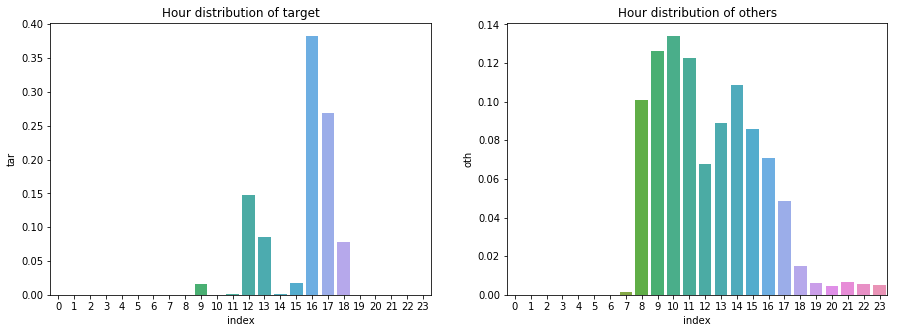

In [39]:
hour_tar = td.loc[td['target']==1, 'hour' ].value_counts(normalize=True)
hour_oth = td.loc[td['target']==0, 'hour' ].value_counts(normalize=True)
plot_hour = pd.DataFrame(index=range(0,24))
plot_hour['tar'] = hour_tar
plot_hour['oth'] = hour_oth

fig, axis = plt.subplots(1,2,figsize=(15,5))

sns.barplot(x='index', y='tar', data=plot_hour.tar.reset_index(), ax=axis[0])
sns.barplot(x='index', y='oth', data=plot_hour.oth.reset_index(), ax=axis[1])

axis[0].set_title('Hour distribution of target')
axis[1].set_title('Hour distribution of others')

Text(0.5, 1.0, 'Duration distributions by target')

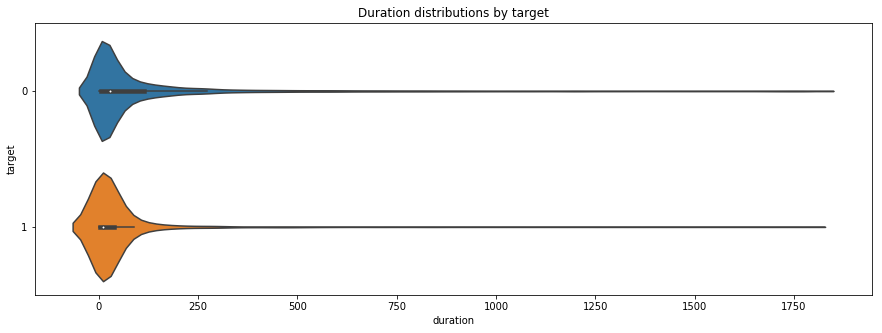

In [66]:
fig, axis = plt.subplots(figsize=(15,5))
sns.violinplot(data=td, y='target',  x='duration', orient='h', ax=axis)
axis.set_title("Duration distributions by target")

Day 5 is Saturday.


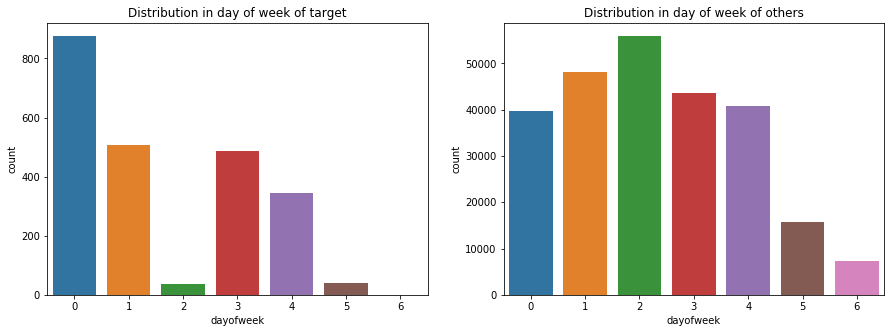

In [72]:
fig, axis = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=td.loc[td['target']==1], x='dayofweek', ax=axis[0])
sns.countplot(data=td.loc[td['target']==0], x='dayofweek', ax=axis[1])

axis[0].set_title('Distribution in day of week of target')
axis[1].set_title('Distribution in day of week of others')

print('Day 5 is Saturday.')

Text(0.5, 1.0, 'Distribution in day of month of others')

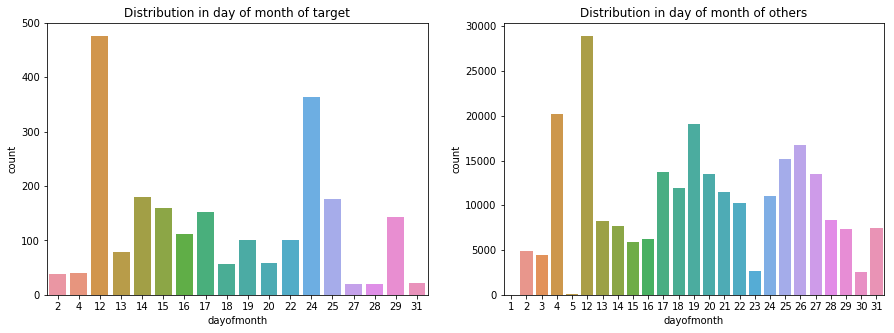

In [76]:
fig, axis = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=td.loc[td['target']==1], x='dayofmonth', ax=axis[0])
sns.countplot(data=td.loc[td['target']==0], x='dayofmonth', ax=axis[1])
axis[0].set_title('Distribution in day of month of target')
axis[1].set_title('Distribution in day of month of others')

Text(0.5, 1.0, 'Sessions frequency for year in others')

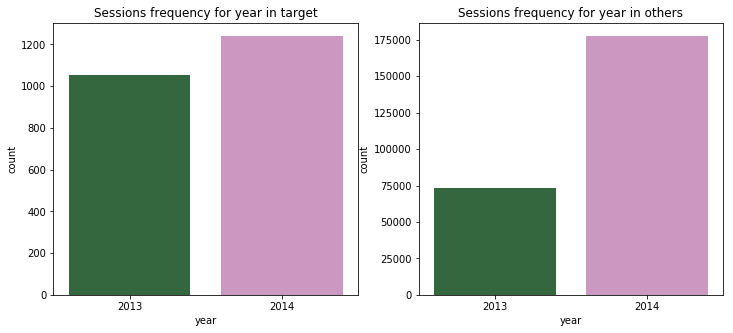

In [106]:
fig, axis = plt.subplots(1,2,figsize=(12,5))
sns.countplot(data=td.loc[td['target']==1], ax=axis[0], x='year', palette='cubehelix')
sns.countplot(data=td.loc[td['target']==0], ax=axis[1], x='year', palette='cubehelix')

axis[0].set_title('Sessions frequency for year in target')
axis[1].set_title('Sessions frequency for year in others')

### First Hypotesis' Conclusions
1. There is difference in distributions between target and others in:
    - hour
    - dayofweek
    - dayofmonth
    - year
2. There is no difference in:
    - duration

In [140]:
good_features = ['hour','dayofweek','dayofmonth','year', 'morning', 'day', 'night', 'evening']
def add_td(df, sparse_matrix):
    X = sparse_matrix
    for i in good_features:
        new_feat = StandardScaler().fit_transform(df[i].values.reshape(-1,1))
        X = hstack([X, new_feat])
    return X

In [133]:
X_train_time = add_td(td, X_train)
X_test_time = add_td(td_test, X_test)

In [134]:
score6 = cv_scores(X_train_time, y_train, c=0.21544)
print(score6)
print(score6.mean())

[0.75031991 0.69560259 0.97266781 0.98251487 0.89934514 0.96640982
 0.9538147  0.93794442 0.97754846 0.97644233]
0.9112610053163974


In [146]:
logit = LogisticRegression(C=0.21544, random_state=17, solver='liblinear')
logit.fit(X_train_time, y_train)

LogisticRegression(C=0.21544, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [147]:
prediction5 = logit.predict_proba(X_test_time)[:,1]
write_to_submission_file(prediction5, 'submission5.csv')

#### Let's try with different features! 

In [155]:
score_base = cv_scores(X_train, y_train)

good_features = ['hour', 'morning', 'day', 'evening', 'night']
X_train_tmp = add_td(td, X_train)
score_hour = cv_scores(X_train_tmp, y_train)

good_features = ['dayofweek']
X_train_tmp = add_td(td, X_train)
score_dayofweek = cv_scores(X_train_tmp, y_train)

good_features = ['dayofmonth']
X_train_tmp = add_td(td, X_train)
score_dayofmonth = cv_scores(X_train_tmp, y_train)

good_features = ['year']
X_train_tmp = add_td(td, X_train)
score_year = cv_scores(X_train_tmp, y_train)

good_features = ['duration']
X_train_tmp = add_td(td, X_train)
score_duration = cv_scores(X_train_tmp, y_train)

print('hour: {}\nweek: {}\nmonth: {}\nyear{}'.format(score_hour.mean(), score_dayofweek.mean(), score_dayofmonth.mean(), score_year.mean()))

hour: 0.906602072529758
week: 0.8699845166788277
month: 0.86230706946284
year0.8734093496399253


In [158]:
print('base: {}\nduration: {}\nhour: {}\nweek: {}\nmonth: {}\nyear{}'.format(score_base.mean(), score_duration.mean(), score_hour.mean(), score_dayofweek.mean(), score_dayofmonth.mean(), score_year.mean()))

base: 0.8677201841035801
duration: 0.868377368386423
hour: 0.906602072529758
week: 0.8699845166788277
month: 0.86230706946284
year0.8734093496399253


In [160]:
good_features = ['hour', 'morning', 'day', 'evening', 'night', 'dayofweek', 'year']
X_train_tmp = add_td(td, X_train)
score_final = cv_scores(X_train_tmp, y_train)
print(score_final.mean())

0.9105367321984094


In [161]:
good_features = ['duration', 'hour', 'morning', 'day', 'evening', 'night', 'dayofweek', 'year']
X_train_tmp = add_td(td, X_train)
score_final2 = cv_scores(X_train_tmp, y_train)
print(score_final2.mean())
print('it_improves')

NameError: name 'score_final2' is not defined

In [163]:
score_final.mean()

0.9113137339983701

In [164]:
good_features = ['duration', 'dayofmonth', 'hour', 'morning', 'day', 'evening', 'night', 'dayofweek', 'year']
X_train_tmp = add_td(td, X_train)
score_final3 = cv_scores(X_train_tmp, y_train)
print(score_final3.mean())
print('it_decreases')

0.9092283375228145


## Here we got our final time features!

In [169]:
good_features = ['duration', 'hour', 'morning', 'day', 'evening', 'night', 'dayofweek', 'year']
X_train_time = add_td(td, X_train)
X_test_time = add_td(td_test, X_test)
print(X_train_time.shape)
print(X_test_timej.shape)

(253561, 50008)
(82797, 50008)


### Now let's go with hyperparameters!

In [173]:
logit_grid_searcher.fit(X_train_time, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 24.3min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)